### Genetic Algorithm to Identify Optimal Routes
##### This notebook implements code from Ramez Shendy's Medium article on using genetic algorithms to solve computationally hard problems like the travelling salesman problem. 
To start, the travelling salesman problem (TSP) is a problem which no known polynomial time solution is known. The traveler starts at a city and must visit each city once and return to the starting city. With each additional city that must be visited, the number of possible solutions increases factorially according to the equation (where n = number of cities that must be visited): (n-1)! * n. Therefore, the amount of compute time needed to solve this problem also grows factorially, making it impractical to test and compare every solution as the requirements of the salesman increases. Instead, many computer scientists have developed heuristic solutions that use simple rules to limit the size of the problem space to solutions that are more likely to be optimal. One such strategy is the genetic algorithm that borrows concepts from evolutionary biology to generate and explore optimal solutions.  

In [234]:
# run in python terminal to install required packages into venv
# py -m pip install -r requirements.txt
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import permutations
import random

# optional animation
from matplotlib.animation import PillowWriter

In [235]:
# grab the locations and store into pandas df
locations_df = pd.read_csv("locations_nn_suboptimalv2.csv")

locations_df

# can calculate the number of permutations would have to search
str(math.factorial(len(locations_df)-1) * len(locations_df)) + " possible solutions"

'40320 possible solutions'

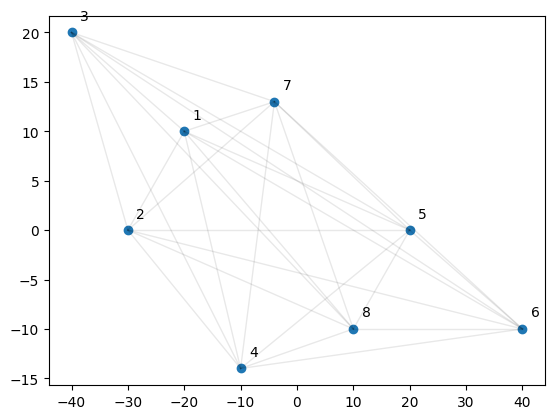

In [236]:
# show plot
fig, ax = plt.subplots()

ax.plot(locations_df.x, locations_df.y, 'o')

# draw all possible edge connections
for i in range(len(locations_df.x)):
    for j in range(i+1, len(locations_df.x)):
        ax.plot([locations_df.x[i], locations_df.x[j]], [locations_df.y[i], locations_df.y[j]], 'k-', alpha=.09, linewidth = 1)

for i, loc in enumerate(locations_df.location):
    ax.annotate(str(loc), (locations_df.x[i] + 1.5, locations_df.y[i] + 1.25), fontsize = 10)

##### The genetic algorithm is commonly used for search and optimization problems. 
It starts by defining a population. Each solution generated is an individual in the population. 

In [237]:
# define the initial population
def initial_population(locations_df = pd.DataFrame, n_population = int):
    # start by creating population of permutations of the locations
    population_perms = []
    possible_perms = list(permutations(list(locations_df.location)))
    random_ids = random.sample(range(0, len(possible_perms)), n_population)
    
    # loop through list of random ids and append to population list
    for i in random_ids:
        population_perms.append(list(possible_perms[i]))
        
    return population_perms

In [238]:
# create a distance matrix between all positions that can be accessed
def euclid_distance_matrix(df = pd.DataFrame):
    # create empty matrix of necessary size
    n = len(df)
    dist_matrix = np.zeros((n, n), dtype=float)
    
    # prespecify the location coord list
    location_i = []
    location_j = []
    
    # fill matrix by calculating dist between appropriate locations
    for i in range(n):
        for j in range(n):
            location_i = [df.x.iloc[i], df.y.iloc[i]]
            location_j = [df.x.iloc[j], df.y.iloc[j]]
            
            # calculate euclid distance
            dist = np.sqrt(
                np.pow(location_i[0] - location_j[0], 2) + np.pow(location_i[1] - location_j[1], 2)
            )
            
            dist_matrix[i][j] = dist
    
    return dist_matrix
    
dist_matrix = euclid_distance_matrix(locations_df)

In [239]:
# will measure the efficiency of the different solutions using distance
def euclid_distance(location_1 = int, location_2 = int):
    # input location id from df
    location_1 = list(locations_df[['x', 'y']].iloc[location_1 - 1])
    location_2 = list(locations_df[['x', 'y']].iloc[location_2 - 1])
    
    return np.sqrt(
        np.pow(location_1[0] - location_2[0], 2) + np.pow(location_1[1] - location_2[1], 2)
    )

In [240]:
# find the value of the individual (route)
def total_distance_individual(individual):
    total_dist = 0
    
    # loop through list of locations and caclulate their distances
    for i in range(0, len(individual)):
        # get location i subtract 1 to access in matrix
        location_1_index = individual[i] - 1
        
        if(i == len(individual) - 1):
            location_2_index = individual[0] - 1
            # route back to starting location 
            total_dist += dist_matrix[location_1_index][individual[0] - 1]
        else:
            location_2_index = individual[i+1] - 1
            # find distance between location and next
            total_dist += dist_matrix[location_1_index][location_2_index]
    
    return total_dist

In [241]:
total_distance_individual([2, 8, 7, 6, 5, 4, 3, 1])

np.float64(255.1181687243137)

##### Can now calculate the distance of each generated solution. Only have a small subset at the moment. Now can calculate their fitness to determine who will 'reproduce' and influence successive generations of solutions/individuals. 

In [242]:
# define the fitness probabilty 
def fitness_probability(population):
    total_distance_all_individuals = []
    
    # loop through population list
    for i in range(0, len(population)):
        total_distance_all_individuals.append(
            total_distance_individual(population[i])
        )
    
    # calculate the fitness probabilty of each individual
    # given more fitness for shorter routes, standardized into prob
    pop_fitness = max(total_distance_all_individuals) - total_distance_all_individuals
    pop_fitness_probs = pop_fitness / sum(pop_fitness)
    
    return pop_fitness_probs
        

##### Selection will use the roulette wheel algorithm to select higher fitness individuals more often for 'reproduction'.

In [243]:
# roulette wheel selection of individuals based on probability
def roulette_wheel(population, fitness_probs):
    # output an individual by grabbing random individual from population
    population_fitness_probs_cumsum = fitness_probs.cumsum()
    bool_prob_array = population_fitness_probs_cumsum < np.random.uniform(0, 1, 1)
    selected_individual_index = len(bool_prob_array[bool_prob_array == True]) - 1
    
    return population[selected_individual_index]

##### Explore other potential solutions using crossover. 
Will cross-over the genetic material of one individual with another like the meiotic process of recombination to generate genetic variation. 

In [244]:
# crossover genetic material of individuals (subroutes)
def crossover(parent_1, parent_2):
    # output two new offspring from two parents
    # determine cutpoint from sequence length
    n_locations_cut = len(locations_df) - 1
    cut = round(random.uniform(1, n_locations_cut)) # random place in mid
    
    offspring_1 = []
    offspring_2 = []
    
    # create offspring by cutting parent at selected index, fill in 
    # the remaining index with other individual excluding duplicates
    offspring_1 = parent_1[0:cut]
    offspring_1 += [location for location in parent_2 if location not in offspring_1]
    
    offspring_2 = parent_2[0:cut]
    offspring_2 += [location for location in parent_1 if location not in offspring_2]
    
    print(cut)
    
    return offspring_1, offspring_2
    

##### Will also introduce random mutation to more thoroughly explore problem space. 

In [245]:
# mutation function
def mutation(offspring):
    n_location_cut = len(locations_df) - 1
    # grab two random locations from route to swap positions
    index_1 = round(random.uniform(0, n_location_cut))
    index_2 = round(random.uniform(0, n_location_cut))
    
    temp = offspring[index_1]
    offspring[index_1] = offspring[index_2] # swap
    offspring[index_2] = temp # replace
    
    return offspring

#### Parameters
##### The thoroughness of solution generation and exploration can be adjusted through the following parameters:
1. Population size: defines the size of the initial and subsequent populations, higher = more exploration = more time 
2. Crossover rate: maintains variation in exploration, higher = more frequent recombination of offspring
3. Mutation rate: rate of random swaps that can help escape local optima, higher = more frequent random swaps
4. Number of generations: how many generations or iterations will the GA run?
5. Termination criteria: when should it stop? Can use the number of generations or other threshold to determine when search is over. 

In [246]:
# set parameters
n_population = 200
crossover_rate = .9
mutation_rate = .5
n_generations = 100

# list for plotting
best_of_the_generation = []

#### Run the genetic algorithm and visualize the results

In [247]:
# the ga
def run_ga(
    locations_df = locations_df, n_population = n_population, 
    n_generations = n_generations, crossover_rate = crossover_rate, 
    mutation_rate = mutation_rate
):
    # init population and find fitness of individuals 
    pop = initial_population(locations_df, n_population)
    fitness_probs = fitness_probability(pop)
    
    parents_list = []
    
    # for subset of individuals set by crossover rate, use roulette wheel
    # to determine who should participate in crossover step
    for i in range(0, int(crossover_rate * n_population)):
        parents_list.append(roulette_wheel(pop, fitness_probs))
    
    offspring_list = []
    
    # crossover the selection of parents to create offspring, iterate 
    # two at a time
    for i in range(0, len(parents_list), 2):
        # recombination
        offspring_1, offspring_2 = crossover(parents_list[i], parents_list[i+1])
        
        # determine whether offspring should mutate
        mutate_threshold = random.random()
        if(mutate_threshold > (1-mutation_rate)):
            offspring_1 = mutation(offspring_1)
        
        mutate_threshold = random.random()
        if(mutate_threshold > (1-mutation_rate)):
            offspring_2 = mutation(offspring_2)

        offspring_list.append(offspring_1)
        offspring_list.append(offspring_2)
        
    # mix in the new offspring with parents to create new population
    mixed_offspring = parents_list + offspring_list
    
    # find the best solutions to create better population
    fitness_probs = fitness_probability(mixed_offspring)
    sorted_fitness_probs = np.argsort(fitness_probs)[::-1] # descend
    best_fitness_indices = sorted_fitness_probs[0:n_population] # selection
    
    # grab those offspring
    best_mixed_offspring = []
    for i in best_fitness_indices:
        best_mixed_offspring.append(mixed_offspring[i])
    
    # begin generation loop
    for i in range(0, n_generations):     
        # rerun the selection, recombination, and mutation processes
        fitness_probs = fitness_probability(best_mixed_offspring)
        parents_list = []
        for i in range(0, int(crossover_rate * n_population)):
            parents_list.append(roulette_wheel(best_mixed_offspring, fitness_probs))
        
        offspring_list = []
        for i in range(0, len(parents_list), 2):
            offspring_1, offspring_2 = crossover(parents_list[i], parents_list[i+1])
            mutate_threshold = random.random()
            if(mutate_threshold > (1-mutation_rate)):
                offspring_1 = mutation(offspring_1)
        
            mutate_threshold = random.random()
            if(mutate_threshold > (1-mutation_rate)):
                offspring_2 = mutation(offspring_2)

            offspring_list.append(offspring_1)
            offspring_list.append(offspring_2)

        mixed_offspring = parents_list + offspring_list
        fitness_probs = fitness_probability(mixed_offspring)
        sorted_fitness_probs = np.argsort(fitness_probs)[::-1] # descend
        best_fitness_indices = sorted_fitness_probs[0:int(.8*n_population)] # subset selection
        
        best_of_the_generation.append(mixed_offspring[best_fitness_indices[0]])
    
        # grab those offspring
        best_mixed_offspring = []
        for i in best_fitness_indices:
            best_mixed_offspring.append(mixed_offspring[i])
        
        # remain some old individuals (20%)
        old_population_indices = [random.randint(0, (n_population - 1)) for j in range(int(.2*n_population))]
        
        for i in old_population_indices:
            best_mixed_offspring.append(pop[i])
        
        # shuffle them up
        random.shuffle(best_mixed_offspring)
        
    return best_mixed_offspring

In [ ]:
# run algorithm and return final population
best_mixed_offspring = run_ga()

4
6
4
2
2
2
5
7
5
3
3
3
6
5
4
5
3
6
3
4
5
7
6
1
3
2
1
2
6
4
4
2
1
1
5
1
6
6
3
1
6
5
3
4
4
7
3
4
5
3
4
4
6
3
2
7
6
1
7
4
3
2
6
6
1
5
6
7
6
4
2
2
5
3
1
6
3
5
6
2
2
6
4
7
3
7
2
1
3
5
2
2
5
2
1
4
5
1
4
3
2
3
3
2
7
5
6
1
5
5
6
2
1
2
3
7
2
6
5
4
4
4
1
1
6
2
3
1
3
2
7
2
4
3
2
3
1
1
1
3
4
3
1
5
4
2
2
1
2
2
6
2
5
1
7
5
3
2
6
2
5
4
2
6
2
2
3
5
2
5
5
2
5
2
6
6
2
2
3
4
6
2
5
5
6
5
3
5
3
2
2
2
6
4
5
2
6
2
5
2
4
4
5
6
2
4
5
6
2
5
6
5
2
2
2
5
2
2
7
3
3
3
2
5
3
3
6
4
4
3
1
2
6
4
5
3
4
4
6
3
7
4
5
5
5
3
7
7
4
2
4
6
4
2
5
1
5
4
6
6
3
7
6
6
5
6
4
7
3
3
4
3
4
3
5
4
7
4
3
3
3
4
3
6
5
5
2
1
4
5
6
3
5
1
5
6
4
3
5
6
1
6
6
6
4
1
3
4
5
7
5
1
2
5
4
3
5
2
2
6
2
6
1
6
5
1
5
5
3
7
2
7
5
3
1
4
7
7
6
2
3
5
2
5
5
7
3
3
3
5
5
5
6
4
3
3
2
3
7
2
3
2
6
3
2
4
6
3
2
6
4
5
3
2
7
1
6
3
2
5
6
4
4
3
7
2
3
7
4
3
3
5
3
5
7
2
3
2
4
6
4
5
1
3
5
5
3
4
7
5
4
6
6
4
3
7
4
3
2
5
5
4
4
2
6
3
6
5
5
2
6
1
5
1
2
4
3
3
5
1
5
3
6
2
5
6
6
5
5
1
2
3
6
3
4
2
3
2
6
2
2
6
4
6
2
4
5
4
3
5
3
7
4
6
4
2
3
5
1
1
6
4
3
7
2
3
3
1
3
3
3
4
4
6
4
4
4
1
6
2


In [ ]:
# calculate the winning distance
total_distance_all_individuals = []
for i in range(0, len(best_mixed_offspring)):
    total_distance_all_individuals.append(total_distance_individual(best_mixed_offspring[i]))

index_minimum_dist = np.argmin(total_distance_all_individuals)
minimum_dist = min(total_distance_all_individuals)

shortest_path = best_mixed_offspring[index_minimum_dist]

# view what won
print(shortest_path, round(minimum_dist, 1))

[5, 7, 1, 3, 2, 4, 8, 6] 185.5


#### Visualize the results
Take a look at the effectiveness of various solutions and their distribution. 

(array([160.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   3.,
          2.,   2.,   3.,   3.,   2.,   2.,   4.,   3.,   0.,   2.,   1.,
          1.,   1.,   0.,   0.,   2.,   0.,   3.,   4.]),
 array([185.46473733, 191.47095473, 197.47717212, 203.48338951,
        209.4896069 , 215.49582429, 221.50204169, 227.50825908,
        233.51447647, 239.52069386, 245.52691125, 251.53312864,
        257.53934604, 263.54556343, 269.55178082, 275.55799821,
        281.5642156 , 287.57043299, 293.57665039, 299.58286778,
        305.58908517, 311.59530256, 317.60151995, 323.60773734,
        329.61395474, 335.62017213, 341.62638952, 347.63260691,
        353.6388243 , 359.64504169, 365.65125909]),
 <BarContainer object of 30 artists>)

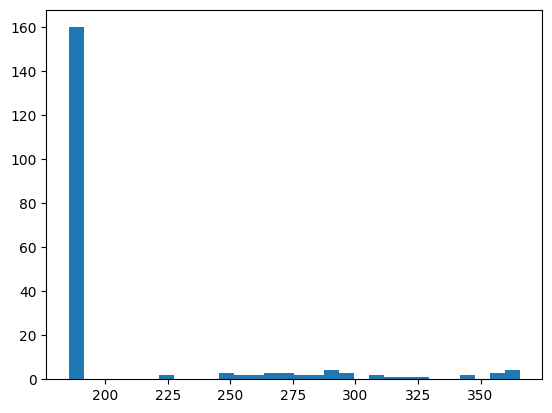

In [251]:
plt.hist(total_distance_all_individuals, bins = 30)

View the final winning path

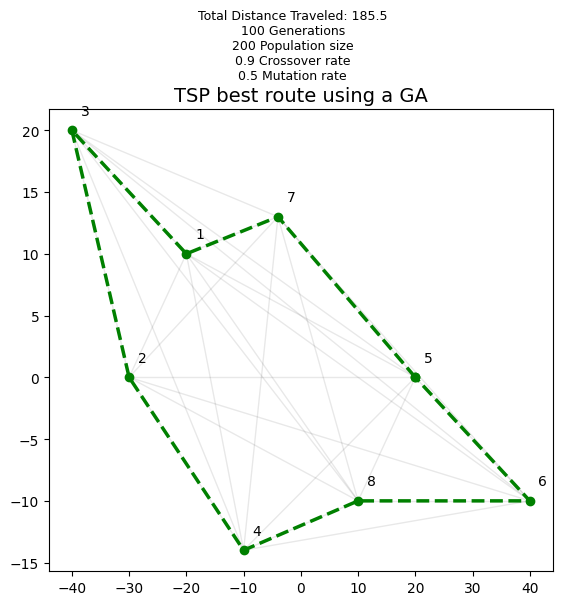

In [252]:
x_shortest = []
y_shortest = []
for location in shortest_path:
    x_value = locations_df['x'].iloc[location - 1]
    y_value = locations_df['y'].iloc[location - 1]
    x_shortest.append(x_value)
    y_shortest.append(y_value)
    
x_shortest.append(x_shortest[0])
y_shortest.append(y_shortest[0])

fig, ax = plt.subplots()

for i in range(len(locations_df.x)):
    for j in range(i+1, len(locations_df.x)):
        ax.plot([locations_df.x[i], locations_df.x[j]], [locations_df.y[i], locations_df.y[j]], 'k-', alpha=.09, linewidth = 1)

ax.plot(x_shortest, y_shortest, '--go', linewidth = 2.5)

plt.title(label = "TSP best route using a GA", fontsize = 14, color = 'k')

str_params = '\n'+str(n_generations)+' Generations\n'+str(n_population)+' Population size\n'+str(crossover_rate)+' Crossover rate\n'+str(mutation_rate)+' Mutation rate'
plt.suptitle("Total Distance Traveled: "+str(round(minimum_dist, 1))+str_params, fontsize = 9, y = 1.047)

for i, loc in enumerate(shortest_path):
    ax.annotate(str(loc), (x_shortest[i] + 1.5, y_shortest[i] + 1.25), fontsize = 10)
    
fig.set_size_inches(6.5, 6)
plt.show()

##### Animation
Can view an animation of the development of optimal routes across the generations using the code below.

In [253]:
# set the writer output, pillowwriter is best for gif output
metadata = dict(title='Optimal Path Generation', artist ='Luke Watson')
writer = PillowWriter(fps=3, metadata=metadata)

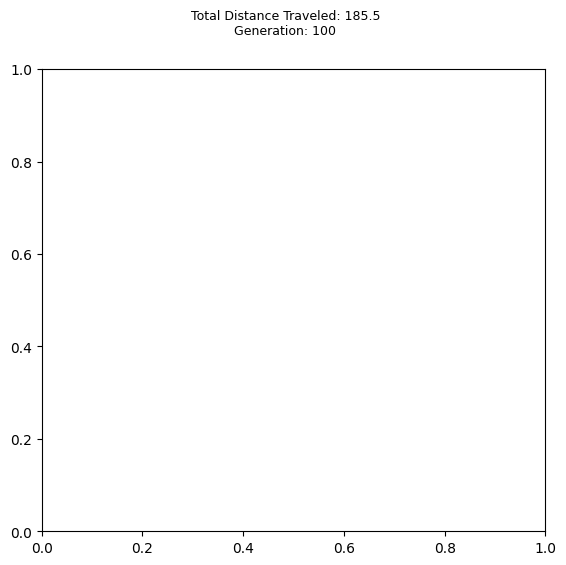

In [254]:
fig, ax = plt.subplots()
fig.set_size_inches(6.5, 6)

# create figures and save with pillowwriter, specify file name and dpi
with writer.saving(fig, "generation_movie_suboptimalv2.gif", 100):
    generation = 0
    
    for path in best_of_the_generation:
        generation += 1
        distance = total_distance_individual(path)
        for i in range(len(locations_df.x)):
            for j in range(i+1, len(locations_df.x)):
                ax.plot([locations_df.x[i], locations_df.x[j]], [locations_df.y[i], locations_df.y[j]], 'k-', alpha=.09, linewidth = 1)
        
        path_x = []
        path_y = []
        
        for location in path:
            x_value = locations_df.x.iloc[location - 1]
            y_value = locations_df.y.iloc[location - 1]
            path_x.append(x_value)
            path_y.append(y_value)
        
        path_x.append(path_x[0])
        path_y.append(path_y[0])
        
        ax.plot(path_x, path_y, '--go', linewidth = 2.5)
        
        plt.title(label = "TSP best route using a GA", fontsize = 14, color = 'k')
    
        plt.suptitle("Total Distance Traveled: "+str(round(distance, 1))+"\n"+"Generation: "+str(generation), fontsize = 9)
            
        writer.grab_frame()
        
        # clear the previous plot
        ax.clear()
        